# Análise Macroeconômica da Noruega (1995–2025)

Este notebook tem como objetivo realizar uma **análise de dados macroeconômicos da Noruega** no período de 1995 a 2025.  
A proposta é examinar os principais **agregados macroeconômicos** e indicadores de política econômica, relacionando-os aos conceitos estudados na disciplina de Economia A, bem como a outros elementos importantes da dinâmica econômica do país.

---

## Objetivos da Análise
- Explorar a evolução do **Produto Interno Bruto (PIB)** e de seus componentes pela ótica da demanda agregada (C + I + G + X − M).
- Avaliar a **inflação** e seus determinantes, com destaque para o Índice de Preços ao Consumidor (CPI).
- Estudar a dinâmica do **mercado de trabalho**, observando a taxa de desemprego.
- Examinar a condução da **política monetária**, através da taxa básica de juros definida pelo Norges Bank.
- Analisar o comportamento do **câmbio** (NOK/EUR e NOK/USD).
- Avaliar o **Balanço de Pagamentos**, com ênfase na Conta Corrente.
- Discutir o papel estratégico da **produção de petróleo e gás** e do **Fundo Soberano (Government Pension Fund Global – GPFG)** na economia norueguesa.

---

## Fontes de Dados Utilizadas
Para garantir a **confiabilidade e a veracidade** das informações, os dados serão coletados de **instituições oficiais norueguesas** e de **organizações internacionais reconhecidas**, conforme listado abaixo:

- **Statistics Norway (SSB / StatBank)**  
  Fonte oficial de estatísticas econômicas e sociais da Noruega.  
  - PIB e componentes (Contas Nacionais)  
  - Inflação (CPI e CPI-ATE)  
  - Mercado de trabalho (AKU/Labour Force Survey)  
  - Balanço de Pagamentos (Conta Corrente)  
  [🔗 SSB StatBank](https://www.ssb.no/en/statbank)

- **Norges Bank (Banco Central da Noruega)**  
  Responsável pela política monetária e dados financeiros.  
  - Taxa básica de juros (Key Policy Rate)  
  - Séries de câmbio (NOK/EUR, NOK/USD)  
  [🔗 Norges Bank Statistics](https://www.norges-bank.no/en/topics/Statistics/)

- **Norwegian Petroleum / Norwegian Offshore Directorate**  
  Informações oficiais sobre produção de petróleo e gás, fundamentais para entender a balança externa da Noruega.  
  [🔗 Norwegian Petroleum](https://www.norskpetroleum.no/en/)

- **Norges Bank Investment Management (NBIM)**  
  Dados do **Government Pension Fund Global (GPFG)**, o fundo soberano norueguês.  
  [🔗 NBIM – Government Pension Fund Global](https://www.nbim.no/)

- **Fontes internacionais complementares** (quando necessário para comparação):  
  - **World Bank Data**: [https://data.worldbank.org/](https://data.worldbank.org/)  
  - **OECD Statistics**: [https://stats.oecd.org/](https://stats.oecd.org/)  
  - **Eurostat**: [https://ec.europa.eu/eurostat](https://ec.europa.eu/eurostat)

---

## Estrutura do Trabalho
1. **Coleta dos dados brutos** via APIs e arquivos CSV/Excel das instituições citadas.  
2. **Tratamento e padronização**: ajuste de frequências (mensal, trimestral, anual), normalização de unidades e criação de métricas derivadas (variações YoY, QoQ, %PIB, etc.).  
3. **Análise exploratória (EDA)**: visualizações e estatísticas descritivas para cada variável-chave.  
4. **Relações macroeconômicas**: correlações, regressões simples e comparação com teoria econômica.  
5. **Discussão e interpretação**: integração dos resultados com o arcabouço teórico da disciplina e análise do papel do petróleo e do fundo soberano.  
6. **Conclusão e síntese**: principais tendências observadas na economia norueguesa ao longo de 30 anos.

---

> ⚡ Este notebook é, portanto, tanto um exercício prático de **análise de dados em Python** quanto uma oportunidade de aprofundar a compreensão da macroeconomia aplicada a um país com características singulares, como a Noruega.



In [10]:
#imports
import os, json, datetime as dt
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

#criando pasta de dados
for p in ['data/raw/ssb', 'data/raw/norges_bank', 'data/raw/other',
'data/processed', 'figs', 'docs']:
    os.makedirs(p, exist_ok = True)

#viaveis globais
#variação ano contra ano (12 meses)
def yoy(s):
    return s.pct_change(12) * 100
#variação trimestre contra trimestre
def qoq(s):
    return s.ptc_change(1) * 100
#log de proveniência
def log_proveniencia(source, url, params = None, outfile = None, notes = None):
    entry = {
        'timestamp': dt.datetime.utcnow().isoformat()+'Z',
        'source': source,
        'url': url,
        'params': params,
        'outfile': outfile,
        'notes': notes
    }
    with open('docs/proviniencia.jsonl', 'a', encoding = 'utf-8') as f:
        f.write(json.dumps(entry, ensure_ascii = False) + '\n')

#catálogo de dados
catalogo = pd.DataFrame([
    ["PIB e componentes (National Accounts)", "SSB StatBank", "Trimestral", "https://www.ssb.no/en/statbank"],
    ["Inflação (CPI, CPI-ATE)", "SSB StatBank", "Mensal", "https://www.ssb.no/en/statbank"],
    ["Desemprego (AKU/LFS)", "SSB StatBank", "Trimestral", "https://www.ssb.no/en/statbank"],
    ["Conta Corrente (BP)", "SSB StatBank", "Trimestral", "https://www.ssb.no/en/statbank"],
    ["Taxa básica (Policy Rate)", "Norges Bank", "Mensal", "https://www.norges-bank.no/en/topics/Statistics/"],
    ["Câmbio NOK/EUR, NOK/USD", "Norges Bank", "Mensal", "https://www.norges-bank.no/en/topics/Statistics/"],
    ["Produção de petróleo e gás", "Norwegian Petroleum", "Anual", "https://www.norskpetroleum.no/en/"],
    ["Fundo Soberano (GPFG)", "NBIM", "Anual", "https://www.nbim.no/"]
], columns=["Indicador","Fonte","Frequência","Link"])
catalogo

#salvando catálogo
catalogo.to_csv("docs/catalogo_variaveis.csv", index=False)


C:\Users\felip\AppData\Local\Temp\ipykernel_41412\1789534668.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': dt.datetime.utcnow().isoformat()+'Z',
C:\Users\felip\AppData\Local\Temp\ipykernel_41412\1789534668.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': dt.datetime.utcnow().isoformat()+'Z',


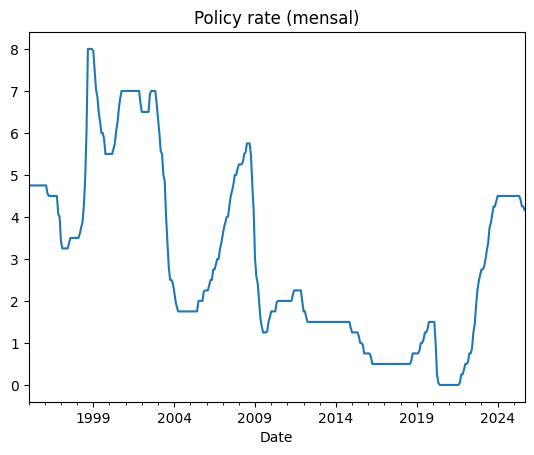

NameError: name 'cpi' is not defined

<Figure size 640x480 with 0 Axes>

In [16]:
# garante estrutura de pastas
os.makedirs("data/raw/norges_bank", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

# leitor robusto para CSV do Norges Bank (detecta delimitador , ou ;)
def read_nb_csv(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, sep=None, engine="python")
    if df.shape[1] == 1:  # ainda pode estar com ';'
        df = pd.read_csv(url, sep=";", engine="python")
    # normaliza nomes (trim)
    df.columns = [c.strip() for c in df.columns]
    return df

# escolhe colunas de tempo e valor com tolerância a variações de nomes
def pick_time_and_value_columns(df: pd.DataFrame):
    up = {c: c.strip().upper() for c in df.columns}

    # coluna de data
    date_col = next((c for c,u in up.items() if u in ("TIME_PERIOD","TIME","DATE","PERIOD","OBS_TIME")), None)
    if date_col is None:
        for c in df.columns:
            try:
                pd.to_datetime(df[c].iloc[:5], errors="raise")
                date_col = c
                break
            except Exception:
                pass
    if date_col is None:
        raise ValueError(f"Não encontrei coluna de data. Colunas: {list(df.columns)}")

    # coluna de valor
    if "OBS_VALUE" in df.columns:
        value_col = "OBS_VALUE"
    else:
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols:
            raise ValueError(f"Não encontrei coluna numérica de valor. Colunas: {list(df.columns)}")
        value_col = num_cols[-1]

    return date_col, value_col


#NORGES BANK — POLICY RATE (MENSAL DIRETO) 
nb_rate_url = "https://data.norges-bank.no/api/data/IR/M.KPRA.SD.?format=csv&startPeriod=1995-01-01&endPeriod=2025-10-02&locale=en"
rate_raw = read_nb_csv(nb_rate_url)

# salva BRUTO exatamente como veio da API 
rate_raw.to_csv("data/raw/norges_bank/policy_rate_monthly_raw.csv", index=False)

# identifica colunas e padroniza
date_col, val_col = pick_time_and_value_columns(rate_raw)
rate_monthly = (
    rate_raw.rename(columns={date_col: "Date", val_col: "policy_rate"})
            .assign(Date=lambda x: pd.to_datetime(x["Date"], errors="coerce"))
            .loc[:, ["Date", "policy_rate"]]
            .dropna(subset=["Date"])
            .set_index("Date")
            .sort_index()
)

# salva processado
rate_monthly.to_parquet("data/processed/policy_monthly.parquet")

# log
log_proveniencia(
    source="Norges Bank",
    url=nb_rate_url,
    outfile="data/raw/norges_bank/policy_rate_monthly_raw.csv",
    notes="Policy rate mensal (API IR/M.KPRA.SD.), leitura robusta de CSV; sem reamostragem."
)


#NORGES BANK — EXCHANGE RATES (BUSINESS / DIAS ÚTEIS)
def norges_bank_fx_business(series_code: str, start='1995-01-01', end='2025-12-31'):
    """
    series_code exemplos (EXR, frequência Business):
      - 'B.EUR.NOK.SP'  Spot EUR/NOK (dias úteis)
      - 'B.USD.NOK.SP'  Spot USD/NOK (dias úteis)
    Lê CSV direto, sem reamostrar. Salva BRUTO por série.
    """
    url = (
        f"https://data.norges-bank.no/api/data/EXR/{series_code}"
        f"?format=csv&startPeriod={start}&endPeriod={end}&locale=en"
    )
    df_raw = read_nb_csv(url)

    # salva BRUTO por série
    raw_name = f"data/raw/norges_bank/exr_{series_code.replace('.','_')}_business_raw.csv"
    df_raw.to_csv(raw_name, index=False)

    # padroniza
    date_col, val_col = pick_time_and_value_columns(df_raw)
    df = (
        df_raw.rename(columns={date_col: "Date", val_col: series_code})
              .assign(Date=lambda x: pd.to_datetime(x["Date"], errors="coerce"))
              .loc[:, ["Date", series_code]]
              .dropna(subset=["Date"])
              .set_index("Date")
              .sort_index()
    )
    return df

eur_b = norges_bank_fx_business("B.EUR.NOK.SP", start='1995-01-01', end='2025-12-31')
usd_b = norges_bank_fx_business("B.USD.NOK.SP", start='1995-01-01', end='2025-12-31')

fx_business = eur_b.join(usd_b, how="outer")
fx_business.columns = ["eurnok", "usdnok"]

# salva PROCESSADO conjunto
fx_business.to_parquet("data/processed/fx_business.parquet")

# log
log_proveniencia(
    source="Norges Bank",
    url="EXR/B.[EUR|USD].NOK.SP?format=csv (Business frequency)",
    outfile="data/processed/fx_business.parquet",
    notes="FX business-day de EUR/NOK e USD/NOK; leitura robusta de CSV; sem reamostragem."
)


# SSB — CPI MENSAL (PxWeb)
def ssb_pxweb(table_id: str, payload: dict, lang='en'):
    url = f"https://api.statbank.no:443/statbank/{lang}/table/{table_id}.PX"
    r = requests.post(url, json=payload, timeout=60)
    r.raise_for_status()
    data = r.json()

    dims = list(data['dimension'].keys())
    labels = [list(data['dimension'][d]['category']['label'].values()) for d in dims]
    idx = pd.MultiIndex.from_product(labels, names=dims)
    values = pd.Series(data['value'], index=idx, name='value').reset_index()
    return values


#VISUALIZAÇÃO RÁPIDA
plt.figure()
rate_monthly['policy_rate'].plot(title="Policy rate (mensal)")
plt.show()

#Deixe o CPI para quando carregar 'cpi' de fato:
plt.figure()
cpi['cpi'].plot(title="CPI (índice)")
plt.show()

plt.figure()
fx_business[['eurnok','usdnok']].plot(title="FX (EUR/NOK, USD/NOK) – Business days")
plt.show()
